Builing a Arabic SynoniumSynonym 

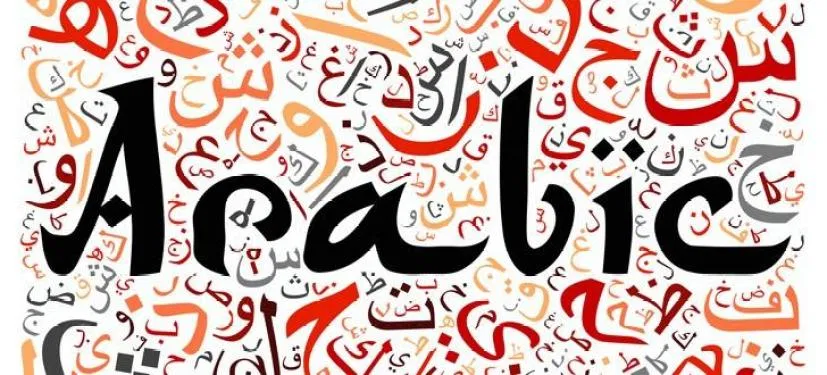

## 2. Train a tokenizer

We choose to train a byte-level Byte-pair encoding tokenizer (the same as GPT-2), with the same special tokens as RoBERTa. Let’s arbitrarily pick its size to be 52,000.

We recommend training a byte-level BPE (rather than let’s say, a WordPiece tokenizer like BERT) because it will start building its vocabulary from an alphabet of single bytes, so all words will be decomposable into tokens (no more `<unk>` tokens!).


In [1]:
# We won't need TensorFlow here
!pip uninstall -y tensorflow
# Install `transformers` from master
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.11.0
# tokenizers version at notebook update --- 0.8.0rc1

Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-9m6mjh7i
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-9m6mjh7i
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3 MB 8.5 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 62.7 MB/s 
  Created wheel for transformers: filename=transformers-4.10.0.dev0-py3-none-any.whl size=2645989 sha256=31a1d692611f792ca88cae1e065e8024fec2540f8206125c4fabeff173f6022a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ld6q92ol/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attemp

In [2]:
%%time 
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path(".").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

CPU times: user 28.7 s, sys: 439 ms, total: 29.2 s
Wall time: 15.1 s


Now let's save files to disk

In [3]:
!mkdir EsperBERTo
tokenizer.save_model("EsperBERTo")

['EsperBERTo/vocab.json', 'EsperBERTo/merges.txt']

🔥🔥 Wow, that was fast! ⚡️🔥

We now have both a `vocab.json`, which is a list of the most frequent tokens ranked by frequency, and a `merges.txt` list of merges.

```json
{
	"<s>": 0,
	"<pad>": 1,
	"</s>": 2,
	"<unk>": 3,
	"<mask>": 4,
	"!": 5,
	"\"": 6,
	"#": 7,
	"$": 8,
	"%": 9,
	"&": 10,
	"'": 11,
	"(": 12,
	")": 13,
	# ...
}

# merges.txt
l a
Ġ k
o n
Ġ la
t a
Ġ e
Ġ d
Ġ p
# ...
```

What is great is that our tokenizer is optimized for Esperanto. Compared to a generic tokenizer trained for English, more native words are represented by a single, unsplit token. Diacritics, i.e. accented characters used in Esperanto – `ĉ`, `ĝ`, `ĥ`, `ĵ`, `ŝ`, and `ŭ` – are encoded natively. We also represent sequences in a more efficient manner. Here on this corpus, the average length of encoded sequences is ~30% smaller as when using the pretrained GPT-2 tokenizer.

Here’s  how you can use it in `tokenizers`, including handling the RoBERTa special tokens – of course, you’ll also be able to use it directly from `transformers`.


In [4]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing


tokenizer = ByteLevelBPETokenizer(
    "./EsperBERTo/vocab.json",
    "./EsperBERTo/merges.txt",
)

In [5]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [ ]:
tokenizer.encode("Mi estas Julien.")

Encoding(num_tokens=7, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
tokenizer.encode("Mi estas Julien.").tokens

['<s>', 'Mi', 'Ġestas', 'ĠJuli', 'en', '.', '</s>']

## 3. Train a language model from scratch

**Update:** This section follows along the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/legacy/run_language_modeling.py) script, using our new [`Trainer`](https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py) directly. Feel free to pick the approach you like best.

> We’ll train a RoBERTa-like model, which is a BERT-like with a couple of changes (check the [documentation](https://huggingface.co/transformers/model_doc/roberta.html) for more details).

As the model is BERT-like, we’ll train it on a task of *Masked language modeling*, i.e. the predict how to fill arbitrary tokens that we randomly mask in the dataset. This is taken care of by the example script.


In [6]:
# Check that we have a GPU
!nvidia-smi

Thu Aug 12 12:31:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

True

### We'll define the following config for the model

In [8]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

Now let's re-create our tokenizer in transformers

In [9]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("./EsperBERTo", max_len=512)

file ./EsperBERTo/config.json not found
file ./EsperBERTo/config.json not found


Finally let's initialize our model.

**Important:**

As we are training from scratch, we only initialize from a config, not from an existing pretrained model or checkpoint.

In [10]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [11]:
model.num_parameters()
# => 84 million parameters

83504416

### Now let's build our training Dataset

We'll build our dataset by applying our tokenizer to our text file.

Here, as we only have one text file, we don't even need to customize our `Dataset`. We'll just use the `LineByLineDataset` out-of-the-box.

In [12]:
%%time
from transformers import LineByLineTextDataset
# paste the path of your dataset here
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="/content/training set.txt",
    block_size=128,
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:124: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


CPU times: user 4.36 s, sys: 232 ms, total: 4.59 s
Wall time: 3.56 s


Like in the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_language_modeling.py) script, we need to define a data_collator.

This is just a small helper that will help us batch different samples of the dataset together into an object that PyTorch knows how to perform backprop on.

In [13]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

### Finally, we are all set to initialize our Trainer

In [14]:
# you can increase the number of epochs for better accuracy
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./EsperBERTo",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_gpu_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

### Start training

In [15]:
%%time
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
***** Running training *****
  Num examples = 93980
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4407
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


Step,Training Loss
500,7.246800
1000,6.695100
1500,6.498600
2000,6.303000
2500,6.265600
3000,6.212400
3500,6.088500
4000,6.058400




Training completed. Do not forget to share your model on huggingface.co/models =)




CPU times: user 7min 33s, sys: 18.7 s, total: 7min 52s
Wall time: 7min 53s


TrainOutput(global_step=4407, training_loss=6.382708018670581, metrics={'train_runtime': 473.2963, 'train_samples_per_second': 595.694, 'train_steps_per_second': 9.311, 'total_flos': 531497032674816.0, 'train_loss': 6.382708018670581, 'epoch': 3.0})

#### 🎉 Save final model (+ tokenizer + config) to disk

In [16]:
trainer.save_model("./EsperBERTo")

Saving model checkpoint to ./EsperBERTo
Configuration saved in ./EsperBERTo/config.json
Model weights saved in ./EsperBERTo/pytorch_model.bin


## 4. Check that the LM actually trained

Aside from looking at the training and eval losses going down, the easiest way to check whether our language model is learning anything interesting is via the `FillMaskPipeline`.

Pipelines are simple wrappers around tokenizers and models, and the 'fill-mask' one will let you input a sequence containing a masked token (here, `<mask>`) and return a list of the most probable filled sequences, with their probabilities.



In [17]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./EsperBERTo",
    tokenizer="./EsperBERTo"
)

loading configuration file ./EsperBERTo/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.10.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading configuration file ./EsperBERTo/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
 

In [18]:
# The sun <mask>.
# =>

fill_mask("أفتضاربانني <mask>.")

[{'score': 0.01590738259255886,
  'sequence': 'أفتضارباننيى.',
  'token': 303,
  'token_str': 'ى'},
 {'score': 0.01388221699744463,
  'sequence': 'أفتضارباننيته.',
  'token': 328,
  'token_str': 'ته'},
 {'score': 0.01284827571362257,
  'sequence': 'أفتضارباننيها.',
  'token': 311,
  'token_str': 'ها'},
 {'score': 0.012241649441421032,
  'sequence': 'أفتضارباننيان.',
  'token': 296,
  'token_str': 'ان'},
 {'score': 0.011065487749874592,
  'sequence': 'أفتضارباننياء.',
  'token': 317,
  'token_str': 'اء'}]

Ok, simple syntax/grammar works. Let’s try a slightly more interesting prompt:



In [19]:
fill_mask("w= 'للمشاورة' <mask>.")

# This is the beginning of a beautiful <mask>.
# =>

[{'score': 0.025414083153009415,
  'sequence': "w= 'للمشاورة'ت.",
  'token': 279,
  'token_str': 'ت'},
 {'score': 0.022757096216082573,
  'sequence': "w= 'للمشاورة'ه.",
  'token': 274,
  'token_str': 'ه'},
 {'score': 0.022454848513007164,
  'sequence': "w= 'للمشاورة'ان.",
  'token': 296,
  'token_str': 'ان'},
 {'score': 0.021840468049049377,
  'sequence': "w= 'للمشاورة',.",
  'token': 261,
  'token_str': ','},
 {'score': 0.01671946980059147,
  'sequence': "w= 'للمشاورة'ها.",
  'token': 311,
  'token_str': 'ها'}]